# Investments notebook

TO DO LIST:

0. comentários com descriçao, input e output;
1. Implement entry rules and position sizing
2. Use copy() and return instead of in-place things in functions.py
3. Write readme file for repository
4. Release first version with basic strategy!

## 0. Make the necessary imports

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from functions import *
import warnings
warnings.filterwarnings('ignore')

## 1. Filter for relevant stocks

### 1.1 Importing stock lists

If you have already generated the lists of high volume stocks and stocks with strong or weak relative strength in comparison to the S&P500, you can simply run the cell below to import these lists. If not, please follow the steps in sections 1.2 and 1.3 to produce these lists. We recommend re-running Secs. 1.2 and 1.3 at least once per month to keep the lists updated

In [2]:
# Imports lists of high volume stock and stocks organized by relative strength from files

high_volume_stocks_df = pd.read_csv("high_volume_stocks.csv").Ticker
strong_stocks_df = pd.read_csv("strong_stocks.csv").Ticker
weak_stocks_df = pd.read_csv("weak_stocks.csv").Ticker

### 1.2 High volume stocks

Low volume stocks carry a higher risk of investment. Thus, it is recommended to focus our attention is stocks that are traded daily with a high volume. In this section, we consider only the stocks which have been traded consistently with an average volume of 200000 in the past 30 days. Given that this process is time consuming, these stocks are saved in a list of high volume stocks for later use. We recommend to re-run this block at least once per month to guarantee that the list of high volume stocks is up to date.

In [ ]:
# Imports tickers from Nasdaq and NYSE

stock_tickers = import_stock_tickers()

# Checks which of the tickers have a volume larger than the 200000 threshold and exports to a data file

high_volume_stocks = produce_high_volume_list(stock_tickers, volume = 200000):
pd.DataFrame(high_volume_stocks,columns=["Ticker"]).to_csv("high_volume_stocks.csv")

### 1.3 Relative strength analysis

Relative strength measures how well a stock has performed in comparison with the market indicator, i.e., the S&P500. Long positions for stocks with large relative strengths and short positions for stocks with small relative strengths are less risky than the other way around. Thus, it is recommended that, during an uptrend, one focuses on stocks with large relative strengths, and vice-versa for downtrends. This section filters the high volume stocks and separates them into two lists, one for strong and one for weak stocks, in comparison with the S&P500, in the past 30 days. These lists are saved in a file. It is recommended to run this block at least once per month to guarantee that the lists are updated.

In [ ]:
# Produces two lists of strong and weak stocks in comparison with the SPX

strong_stocks, weak_stocks = produce_relative_strength_lists(high_volume_stocks, period = 30)
        
# Exports the lists of strong and weak stocks to data files
        
pd.DataFrame(strong_stocks,columns=["Ticker"]).to_csv("strong_stocks.csv")
pd.DataFrame(weak_stocks,columns=["Ticker"]).to_csv("weak_stocks.csv")

## 2. Strategy type selection

### 2.1 Verification of market trend

Use four moving averages with different periods to verify the short-term and long-term trends of the S&P500. This analysis serves to decide wether to go for long or short strategies, when the market is bullish or bearish, respectively. If the market is found to be currently indecisive or trending sideways, it is recommended to stay out of the market. 

In [3]:
market_uptrend, market_downtrend = verify_market_trend()

### 2.2 Verification of price oscillation

Even if the market is found to be currently uptrending or downtrending, one might prefer to stay out of the market in case the market is currently overbought or oversold, respectively. To verify wether this is the case, we recur to a simple stochastic indicator. Long strategies are recommended if the market is uptrending and not overbought, whereas short strategies are recommended if the market is downtrending and not oversold. Otherwise, it is recommended to stay out of the market until it regresses to the mean.

In [4]:
market_oversold, market_overbought = verify_market_stochastic()

### 2.3 Decision for market strategies

Taking into consideration the trend of the market and the current price status, we conclude which type of strategy to follow. If the market is currently uptrending and not in an overbought state, long positions are recommended. If the market is currently downtrending and not in an oversold state, short positions are recommended. Otherwise, it is recommended to stay inective until the market retraces.

Market is currently indecisive.


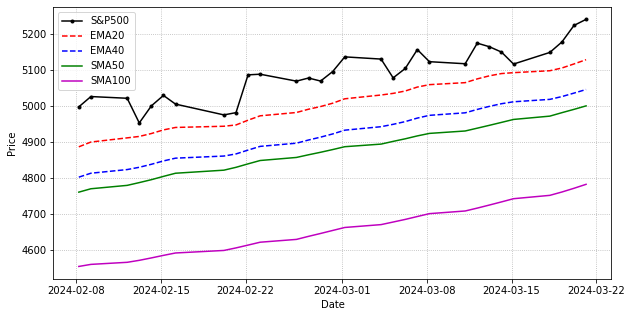

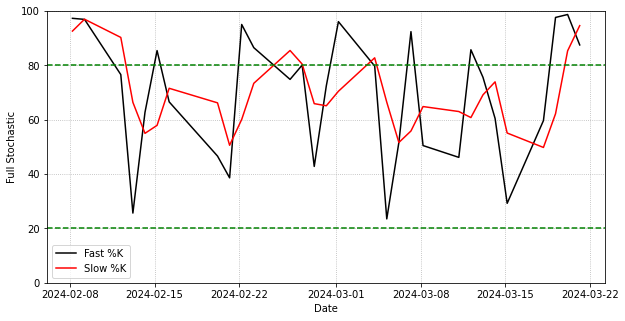

In [3]:
# Analyzed the trend and price status of the market and concludes which strategies are recommended

bias_type, stocks_to_screen = analyze_market(strong_stocks_df.to_list(), weak_stocks_df.to_list())
    
plot_market_conditions()

## 3. Strategy screeners

### 3.1 Basic strategy for bullish markets

Note: we recommend using this strategy when the market is bullish and with strong stocks.

The first strategy in this notebook consists of a basic strategy that takes into account the convergence of four different signals: 

- Signal 1: the price is currently on an uptrend
- Signal 2: the MACD indicator is currently bullish
- Signal 3: the RSI indicator is currently oversold
- Signal 4: a bullish candlestick pattern is detected

IDEA: what if we check for shot-down trends to guarantee that there is a retracement?

If the four signals are detected, a long position is recommended for the stock under consideration.

In [4]:
if bias_type != "Long":
    print("It is not recommended to follow this strategy in the current market condition.")

screener_basic_long(strong_stocks_df.to_list()) 

It is not recommended to follow this strategy in the current market condition.


[]

### 3.2 Basic strategy for bearish markets

Note: we recommend using this strategy when the market is bearish and with weak stocks.

The first strategy in this notebook consists of a basic strategy that takes into account the convergence of four different signals: 

- Signal 1: the price is currently on a downtrend
- Signal 2: the MACD indicator is currently bearish
- Signal 3: the RSI indicator is currently overbought
- Signal 4: a bearish candlestick pattern is detected

If the four signals are detected, a short position is recommended for the stock under consideration.

In [ ]:
if bias_type != "Short":
    print("It is not recommended to follow this strategy in the current market condition.")

screener_basic_short(weak_stocks_df.to_list()) 

0
100


# WHATEVER IS AFTER THIS IS STILL UNDER DEVELOPMENT

## 4. Order placement

### 4.1 Entry rules

For the stocks for which signals were detected through the screeners above, one can now decide to enter the trade. To minimize the risk of losing the trade or entering the trade at the wrong price, it is recommended to follow a strict set of entry rules. These rules define the price at which one enters the trade, and also the prices at which one takes profit or stops the loss. 

TO DO:

- Implement margin calculator
- Implement average true range
- select where the stop goes (below confirmation or below reversal)
- place buy stop and buy limit orders
- place stop loss order

### 4.2 Position sizing

## 5. Backtesting